# Object Detection with KerasCV

In [213]:
import tensorflow as tf
import os
import keras
import keras_cv
import tqdm
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET
from keras_cv import visualization

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

In [214]:
# Check if Keras version is above 3
if int(keras.__version__.split('.')[0]) >= 3:
    print("Keras version", keras.__version__, "is above 3.")
else:
    print("Keras version", keras.__version__, "is below 3. Re-Run Setup.")
    exit(1)


Keras version 3.0.5 is above 3.


### Constants

In [215]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 3
GLOBAL_CLIPNORM = 10.0
VERSION = 3

### Classes

In [216]:
class_ids = [
    "flare",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [217]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids

# Path to images and annotations
voc_version = f"voc_v{VERSION}"
path_images = f"./dataset/{voc_version}/data/images/"
path_annot = f"./dataset/{voc_version}/data/annotations/"

# Get all XML file paths in path and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

# Now, you should iterate over xml_files and pass path to parse_annotation
image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/40 [00:00<?, ?it/s]

In [218]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [219]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [220]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [221]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)


In [222]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [223]:
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)


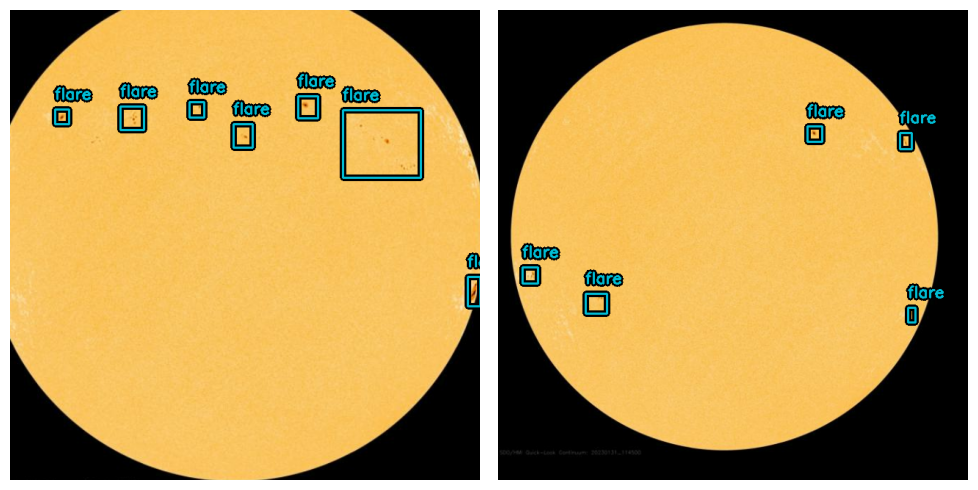

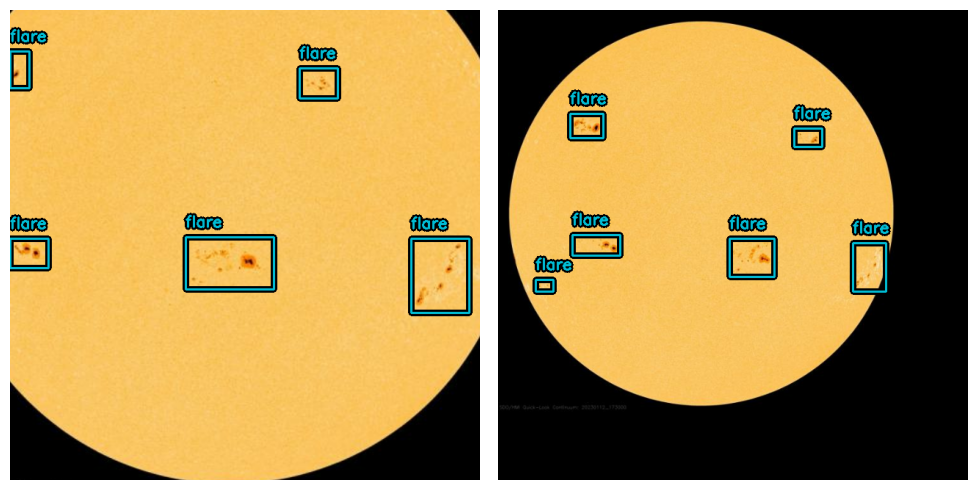

In [224]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=2
)

In [225]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [226]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

In [227]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [228]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [229]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [230]:
!pip install pycocotools

In [231]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.keras")],
)

Epoch 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - loss: 777.2833 - val_loss: 369.4454 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 377.0377

2024-03-07 17:33:42.043758: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [4,7,4] vs. shape[1] = [4,6,4] [Op:ConcatV2] name: concat
Traceback (most recent call last):

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.9/site-packages/tensor

UnknownError: {{function_node __wrapped__EagerPyFunc_Tin_1_Tout_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [4,7,4] vs. shape[1] = [4,6,4] [Op:ConcatV2] name: concat
Traceback (most recent call last):

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.9/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 205, in result_on_host_cpu
    return tf.constant(obj_result(force), obj.dtype)

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.9/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 256, in result
    self._cached_result = self._compute_result()

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.9/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 264, in _compute_result
    _box_concat(self.ground_truths),

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.9/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 44, in _box_concat
    result[key] = tf.concat([b[key] for b in boxes], axis=0)

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/Users/sam.treweek/BJSS/MetOffice/solar-flare/.venv/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 5883, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [4,7,4] vs. shape[1] = [4,6,4] [Op:ConcatV2] name: concat

 [Op:EagerPyFunc] name: 

dict_keys(['loss', 'val_loss', 'MaP', 'MaP@[IoU=50]', 'MaP@[IoU=75]', 'MaP@[area=small]', 'MaP@[area=medium]', 'MaP@[area=large]', 'Recall@[max_detections=1]', 'Recall@[max_detections=10]', 'Recall@[max_detections=100]', 'Recall@[area=small]', 'Recall@[area=medium]', 'Recall@[area=large]'])


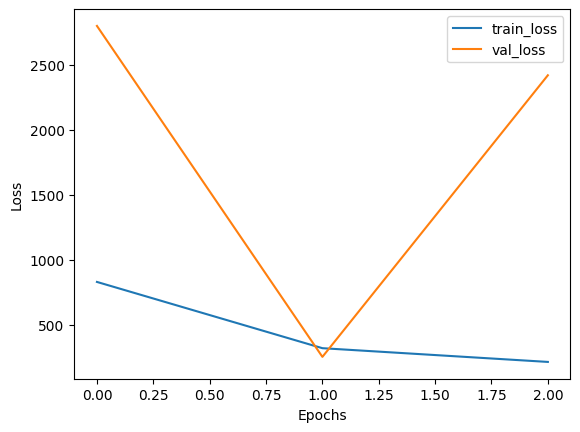

In [ ]:
# Access the training history
print(history.history.keys())  # This will print out the available metrics in the history

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


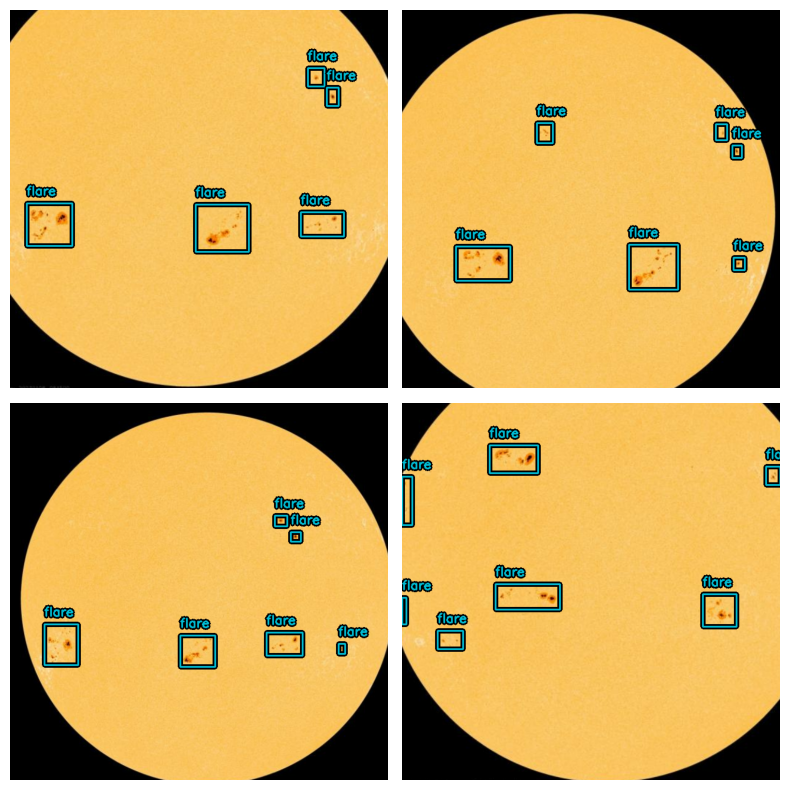

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

visualization_ds = val_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

yolo.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.7,
    confidence_threshold=0.75,
)

visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")